<font style='font-size:1.5em'>🗓️ Week 11 – Applications II: <span style='color:#eaeaea'>text mining  \&</span> network analysis</font>

<font style='font-size:1.2em'>DS105L – Data for Data Science</font>

**AUTHOR:**  Dr. [Jon Cardoso-Silva](https://www.lse.ac.uk/DSI/People/Jonathan-Cardoso-Silva)

**DEPARTMENT:** [LSE Data Science Institute](https://twitter.com/lsedatascience)

**DATE:** 31 March 2023


---

📚 **LEARNING OBJECTIVES**

- Learn the basics of the [`altair`](https://altair-viz.github.io/getting_started/overview.html) library for interactive data visualisation
- Learn how to use [`networkx`](https://networkx.org/) to create and analyse networks
- Learn how to use [Gephi](gephi.org) to play with network visualisations


## Imports 
Section with library imports.

In [516]:
import itertools

import pandas as pd
import networkx as nx
import altair as alt

DATA_DIR = '../data'

### Custom functions
Section with some general functions used over the notebook

In [517]:
def read_data(data, data_dir=DATA_DIR):
    """Reads a JSON file and returns a dataframe.

    Args:
        data (str): Name of the JSON file.
        data_dir (str): Path to the directory where the JSON file is located.

    Returns:
        df (pandas.DataFrame): Dataframe containing the data from the JSON file.

    Raises:
        NotImplementedError: If the JSON file contains more than one list.
                             Know how to handle this? Please open a PR!
    """

    # I found it easier to read the JSON file as a series and then convert it to a dataframe
    df = pd.read_json(f'{data_dir}/{data}.json', typ='series')

    # If the JSON file only contains one single list, parse it as a dataframe
    if len(df) == 1:
        df = pd.DataFrame.from_dict(df.iloc[0])
    else:
        error = f'JSON file {data} contains more than one list. Please check the file.'
        raise NotImplementedError(error)

    return df

def convert_time_to_minutes(x):
    """
    Converts a string of the form '0:01:45' to minutes.
    Thanks, CoPilot 🤖! You saved me a lot of time here.
    """

    # Split the string by ':'
    x = x.split(':')

    # Convert the list of strings to integers
    x = [int(i) for i in x]

    # Convert the list of integers to seconds
    x = x[0] * 60*60 + x[1]  * 60 + x[2]

    return x / 60

# 💽 1: The Data

I am using data collected by [jeffreylancaster/game-of-thrones](https://github.com/jeffreylancaster/game-of-thrones) to create a network of characters from the Game of Thrones series. 

I cloned the repository and copied the `data` folder to the `data` folder of my project. Because the license of the data is permissive, I copied the data to my project and gave credit to the original author (always do that!).

Anyways, let's look at the data I am using.

## 1.1 Character data

In [518]:
df_characters = read_data('characters')
df_characters[['characterName', 'houseName', 'royal']].head(20)

characterName  houseName royal
0       Addam Marbrand        NaN   NaN
1      Aegon Targaryen  Targaryen  True
2        Aeron Greyjoy    Greyjoy   NaN
3   Aerys II Targaryen  Targaryen  True
4                 Akho        NaN   NaN
5       Alliser Thorne        NaN   NaN
6      Alton Lannister  Lannister   NaN
7        Alys Karstark        NaN   NaN
8          Amory Lorch        NaN   NaN
9                Anguy        NaN   NaN
10  Archmaester Marwyn        NaN   NaN
11          Areo Hotah        NaN   NaN
12              Armeca        NaN   NaN
13              Arthur        NaN   NaN
14        Arthur Dayne        NaN   NaN
15          Arya Stark      Stark   NaN
16            Baby Sam        NaN   NaN
17       Balon Greyjoy    Greyjoy   NaN
18     Baratheon Guard  Baratheon   NaN
19     Barristan Selmy        NaN   NaN

## 1.2 Characters groups

Not that this sounds suuper useful.

In [519]:
df_characters_groups = read_data('characters-groups')
df_characters_groups

name                                         characters
0           Stark  [Arya Stark, Benjen Stark, Bran Stark, Catelyn...
1       Targaryen  [Daenerys Targaryen, Drogon, Rhaegal, Viserion...
2       Baratheon  [Joffrey Baratheon, Myrcella Baratheon, Renly ...
3       Lannister  [Cersei Lannister, Jaime Lannister, Kevan Lann...
4   Night's Watch  [Alliser Thorne, Eddison Tollett, Grenn, Jeor ...
5        Dothraki         [Doreah, Irri, Khal Drogo, Rakharo, Qhono]
6         Greyjoy  [Balon Greyjoy, Euron Greyjoy, Theon Greyjoy, ...
7          Tyrell  [Loras Tyrell, Mace Tyrell, Margaery Tyrell, O...
8       Wildlings  [Baby Sam, Craster, Gilly, Mag the Mighty, Man...
9         Martell  [Doran Martell, Ellaria Sand, Nymeria Sand, Ob...
10           Frey    [Black Walder Rivers, Lothar Frey, Walder Frey]
11          Tully                      [Brynden Tully, Edmure Tully]
12  White Walkers  [Mag the Mighty Wight, The Night King, White W...
13        Include  [Archmaester Ebrose, Barristan Selmy, Beric Do...

In [520]:
# I want to be able to select a character by name and get its group
df_characters_groups = df_characters_groups\
                        .explode('characters')\
                        .rename(columns={'characters': 'characterName',
                                         'name': 'group'})\
                        .set_index(['characterName'])

In [521]:
df_characters_groups.head()

group
characterName       
Arya Stark     Stark
Benjen Stark   Stark
Bran Stark     Stark
Catelyn Stark  Stark
Eddard Stark   Stark

## 1.3 Episode data ⭐ 

This is the most interesting dataset.

In [522]:
df_episodes = read_data('episodes')
df_episodes.shape

(73, 8)

In [523]:
# Check how it looks like
df_episodes.head(2)

seasonNum  episodeNum      episodeTitle        episodeLink episodeAirDate  \
0          1           1  Winter Is Coming  /title/tt1480055/     2011-04-17   
1          1           2     The Kingsroad  /title/tt1668746/     2011-04-24   

                                  episodeDescription  \
0  Jon Arryn, the Hand of the King, is dead. King...   
1  While Bran recovers from his fall, Ned takes o...   

                            openingSequenceLocations  \
0     [King's Landing, Winterfell, The Wall, Pentos]   
1  [King's Landing, Winterfell, The Wall, Vaes Do...   

                                              scenes  
0  [{'sceneStart': '0:00:40', 'sceneEnd': '0:01:4...  
1  [{'sceneStart': '0:02:22', 'sceneEnd': '0:05:2...

**Let's look closer at the first episode:**

In [524]:
df_episodes.iloc[0]

seasonNum                                                                   1
episodeNum                                                                  1
episodeTitle                                                 Winter Is Coming
episodeLink                                                 /title/tt1480055/
episodeAirDate                                                     2011-04-17
episodeDescription          Jon Arryn, the Hand of the King, is dead. King...
openingSequenceLocations       [King's Landing, Winterfell, The Wall, Pentos]
scenes                      [{'sceneStart': '0:00:40', 'sceneEnd': '0:01:4...
Name: 0, dtype: object

## 1.4 Exploding scenes 💣

What's in the 'scenes' column?

In [ ]:
df_episodes.iloc[0]['scenes']

In [526]:
len(df_episodes.iloc[0]['scenes'])

36

That is neat! A JSON containing details about characters who co-appear in a scence.

💡 _Later, we will use this data to create a **network** of characters that appear in the same scene._

But first, let's expand the scenes using the good ol' `explode()` function from `pandas`.

In [527]:
df_episodes.head(1).explode('scenes').head()

seasonNum  episodeNum      episodeTitle        episodeLink episodeAirDate  \
0          1           1  Winter Is Coming  /title/tt1480055/     2011-04-17   
0          1           1  Winter Is Coming  /title/tt1480055/     2011-04-17   
0          1           1  Winter Is Coming  /title/tt1480055/     2011-04-17   
0          1           1  Winter Is Coming  /title/tt1480055/     2011-04-17   
0          1           1  Winter Is Coming  /title/tt1480055/     2011-04-17   

                                  episodeDescription  \
0  Jon Arryn, the Hand of the King, is dead. King...   
0  Jon Arryn, the Hand of the King, is dead. King...   
0  Jon Arryn, the Hand of the King, is dead. King...   
0  Jon Arryn, the Hand of the King, is dead. King...   
0  Jon Arryn, the Hand of the King, is dead. King...   

                         openingSequenceLocations  \
0  [King's Landing, Winterfell, The Wall, Pentos]   
0  [King's Landing, Winterfell, The Wall, Pentos]   
0  [King's Landing, Winterfell, The Wall, Pentos]   
0  [King's Landing, Winterfell, The Wall, Pentos]   
0  [King's Landing, Winterfell, The Wall, Pentos]   

                                              scenes  
0  {'sceneStart': '0:00:40', 'sceneEnd': '0:01:45...  
0  {'sceneStart': '0:01:45', 'sceneEnd': '0:03:24...  
0  {'sceneStart': '0:03:24', 'sceneEnd': '0:03:31...  
0  {'sceneStart': '0:03:31', 'sceneEnd': '0:03:38...  
0  {'sceneStart': '0:03:38', 'sceneEnd': '0:03:44...

In case you forgot how `explode()` works, notice that a single row in the original data frame will be expanded into multiple rows, one for each element in the `scenes` list.  

You can confirm that with the following:

In [528]:
print(f"Exploding just the first row of df_episodes "
      f"produces a df with shape: {df_episodes.head(1).explode('scenes').shape}")

Exploding just the first row of df_episodes produces a df with shape: (36, 8)


## 1.5 Building our final dataset

In [529]:
df_got = df_episodes.explode('scenes')

# What's the new shape?
df_got.shape

(4165, 8)

🔐 **Note to attentive reader:** 

Do you fully understand what is going on in the cell below? 

Try running each element of the concat list separately and see if you can understand what is going on. If you don't and you are curious to learn more, just send me a message on Slack and I'll be more than happy to help you out.

In [530]:
def get_characters_list(x):
    """Extracts the characters from the scenes.

    Args:
        x (dict): Dictionary containing the characters.

    Returns:
        characters (list): List of characters.
    """

    # 🐰 Easter egg: there is more potentially useful information in the x dictionary
    # Can you find it?
    characters = sorted([character['name'] for character in x['characters']])
    groups     = [df_characters_groups.loc[character]['group'] 
                  if character in df_characters_groups.index 
                  else None for character in characters ]

    characters = pd.Series({'characters': characters, 'groups': groups})
    return characters

df_got = pd.concat([df_got.drop(columns='scenes'),
                    df_got['scenes'].apply(pd.Series).drop(columns='characters'),
                    df_got['scenes'].apply(get_characters_list)
                    ], axis=1)

In [531]:
print(f"In the end, we are left with {df_got.shape[0]} scenes and {df_got.shape[1]} columns about them.")

In the end, we are left with 4165 scenes and 17 columns about them.


In [532]:
df_got.tail(2)

seasonNum  episodeNum     episodeTitle        episodeLink episodeAirDate  \
72          8           6  The Iron Throne  /title/tt6027920/     2019-05-19   
72          8           6  The Iron Throne  /title/tt6027920/     2019-05-19   

                                   episodeDescription  \
72  In the aftermath of the devastating attack on ...   
72  In the aftermath of the devastating attack on ...   

                     openingSequenceLocations sceneStart sceneEnd  \
72  [Last Hearth, Winterfell, King's Landing]    1:18:20  1:19:40   
72  [Last Hearth, Winterfell, King's Landing]    1:19:40  1:20:20   

             location         subLocation greensight altLocation warg  \
72  North of the Wall            The Wall        NaN         NaN  NaN   
72  North of the Wall  The Haunted Forest        NaN         NaN  NaN   

   flashback                             characters                     groups  
72       NaN  [Ghost, Jon Snow, Tormund Giantsbane]  [Stark, Stark, Wildlings]  
72       NaN  [Ghost, Jon Snow, Tormund Giantsbane]  [Stark, Stark, Wildlings]

# 📊 2: Some interactive visualizations

Tired of static visualizations? Let's make some interactive ones using a library called Altair.

[Altair](https://altair-viz.github.io/gallery/index.html) is a truly fantastic library for creating interactive visualizations in Python. It is built on top of [Vega-Lite](https://vega.github.io/vega-lite/), a JavaScript library for creating interactive visualizations.

Another plus side of Altair is that, similar to what I've been saying about plotnine, it forces you to think about the **data** and not the **plot** itself. 

💡 **Because of this, if you chose to do all your visualisation in Altair, you will also be adhering to the final project dataviz library requirements.**

## Q: How many scenes are there per episode?

To illustrate the power of Altair, let's start with a simple question: how many scenes are there per episode?

Let's keep with the tradition of creating a `plot_df` dataframe with the data we want to plot. This way we minimise the risk of ruining our original data.

In [533]:
selected_cols = ['seasonNum', 'episodeNum', 'sceneStart', 
                 'sceneEnd', 'characters', 'groups',
                 'location', 'subLocation']

plot_df = df_got[selected_cols].copy()
plot_df

seasonNum  episodeNum sceneStart sceneEnd  \
0           1           1    0:00:40  0:01:45   
0           1           1    0:01:45  0:03:24   
0           1           1    0:03:24  0:03:31   
0           1           1    0:03:31  0:03:38   
0           1           1    0:03:38  0:03:44   
..        ...         ...        ...      ...   
72          8           6    1:17:24  1:17:55   
72          8           6    1:17:55  1:18:11   
72          8           6    1:18:11  1:18:20   
72          8           6    1:18:20  1:19:40   
72          8           6    1:19:40  1:20:20   

                               characters                     groups  \
0             [Gared, Waymar Royce, Will]         [None, None, None]   
0             [Gared, Waymar Royce, Will]         [None, None, None]   
0             [Wight Wildling Girl, Will]      [White Walkers, None]   
0                                  [Will]                     [None]   
0                                      []                         []   
..                                    ...                        ...   
72                          [Sansa Stark]                    [Stark]   
72                           [Arya Stark]                    [Stark]   
72  [Ghost, Jon Snow, Tormund Giantsbane]  [Stark, Stark, Wildlings]   
72  [Ghost, Jon Snow, Tormund Giantsbane]  [Stark, Stark, Wildlings]   
72  [Ghost, Jon Snow, Tormund Giantsbane]  [Stark, Stark, Wildlings]   

             location         subLocation  
0            The Wall        Castle Black  
0   North of the Wall  The Haunted Forest  
0   North of the Wall  The Haunted Forest  
0   North of the Wall  The Haunted Forest  
0   North of the Wall  The Haunted Forest  
..                ...                 ...  
72          The North          Winterfell  
72     The Sunset Sea                 NaN  
72           The Wall        Castle Black  
72  North of the Wall            The Wall  
72  North of the Wall  The Haunted Forest  

[4165 rows x 8 columns]

**Time for some pre-processing:**

- `sceneStart` and `sceneEnd` are strings, so we need to convert them to integers
- it will be useful to have a `timeSpan` column, which is the difference between `sceneStart` and `sceneEnd`
- I'll join the `character` names as a string, so that we can use it as a tooltip in the plot later
- I will get the set of `groups` involved in each scene
- Add a `numCharacters` column, which is the number of characters in a scene

In [534]:
# I left this function here, not at the top
# because it is specific to plots
def get_set_groups(x):
    """Extracts the groups from the scenes.

    Args:
        x (dict): Dictionary containing the groups.

    Returns:
        groups (set): Set of groups.
    """

    # Do you get what's going on here with the curly brackets?
    characterGroups = {str(group) for group in x if group is not None}
    return list(characterGroups)

In [535]:
plot_df['sceneStart']    = plot_df['sceneStart'].apply(convert_time_to_minutes)
plot_df['sceneEnd']      = plot_df['sceneEnd'].apply(convert_time_to_minutes)
plot_df['timeSpan']      = plot_df['sceneEnd'] - plot_df['sceneStart']
plot_df['numCharacters'] = plot_df['characters'].apply(len) 
plot_df['characters']    = plot_df['characters'].apply(lambda x: ', '.join(x))
plot_df['groups']        = plot_df['groups'].apply(get_set_groups)
plot_df['numGroups']     = plot_df['groups'].apply(len)

**Now for the plot:**

In the lecture, I will build the plot below step by step, but here is the final result:

In [537]:
# Define the selection dropdown
season_select = alt.binding_select(options=list(range(1, plot_df['seasonNum'].max()+1)))
season_filter = alt.selection_point(fields=['seasonNum'], bind=season_select, name='Season', value=1, nearest=True)

max_num_characters_in_scene = plot_df['numCharacters'].max()
# Round to the next divisible by 5
max_num_characters_in_scene = (max_num_characters_in_scene // 5 + 1) * 5

max_num_groups_in_scene = plot_df['numGroups'].max()
# Round to the next divisible by 5
max_num_groups_in_scene = (max_num_groups_in_scene // 5 + 1) * 5

# Create the Altair chart
chart = alt.Chart(plot_df).properties(
    title='Scene visualizer',
    width=1200,
    height=400
).add_params(
    season_filter
)

# Add the rectangle marks
rects = chart.mark_rect(color='lightgray', opacity=0.8, stroke='black', strokeWidth=0.5).encode(
    y=alt.Y('episodeNum:N', axis=alt.Axis(title='Episode Number')),
    x=alt.X('sceneStart:Q', axis=alt.Axis(title='Time Span (min)', values=list(range(0, 100, 10)))),
    x2=alt.X2('sceneEnd:T'),
    color=alt.Color('numCharacters:Q', 
                    legend=alt.Legend(title='# Characters'),
                    scale=alt.Scale(scheme='turbo', domain=[0, max_num_characters_in_scene])),
    tooltip=[alt.Tooltip('location', title='Scene Location'),
             alt.Tooltip('subLocation', title='Scene Sublocation'),
             alt.Tooltip('numGroups', title='Number of Unique Groups'),
             alt.Tooltip('numCharacters', title='Number of Characters'),
             alt.Tooltip('characters', title='Names')]
).transform_filter(
    season_filter
)

chart = rects

chart = chart.configure_title(fontSize=40)
chart = chart.configure_axis(labelFontSize=20, titleFontSize=30, grid=False)
chart = chart.configure_legend(labelFontSize=20, titleFontSize=20)

chart

alt.Chart(...)

## Q: Does more characters mean more house groups involved in the same scene?

Short answer: yes.

In [538]:
# Create crosstabulation table
ct = pd.crosstab(plot_df['numCharacters'], plot_df['numGroups'])

# Convert crosstabulation to long format
ct_long = ct.reset_index().melt(id_vars='numCharacters', var_name='numGroups', value_name='count')

ct_long

numCharacters numGroups  count
0                0         0    325
1                1         0     39
2                2         0     10
3                3         0      9
4                4         0      2
..             ...       ...    ...
202             18         8      0
203             19         8      0
204             20         8      0
205             21         8      1
206             24         8      1

[207 rows x 3 columns]

In [539]:
# Create bubble plot
bubble_plot = alt.Chart(ct_long).properties(
    title='Number of Characters vs. Number of Groups',
    width=1200,
    height=400
)

max_ct_count = ct_long['count'].max()
# Round up to the next divisible by 100
max_ct_count = (max_ct_count // 100 + 1) * 100

bubble_plot = bubble_plot.mark_circle(opacity=0.9, stroke='black', strokeWidth=0.5).encode(
    x=alt.X('numCharacters:Q', 
            title='Number of Characters', 
            scale=alt.Scale(domain=(-1, ct_long['numCharacters'].max()))),
    y=alt.Y('numGroups:Q', 
            title='Number of Groups',
            scale=alt.Scale(domain=(-1, ct_long['numGroups'].max()))),
    size=alt.Size('count:Q', title='Count', scale=alt.Scale(domain=[0, max_ct_count])),
    color=alt.Color('count:Q', 
                    legend=alt.Legend(title='Count'),
                    scale=alt.Scale(scheme='lightorange', domain=[0, max_ct_count])),
)

bubble_plot = bubble_plot.configure_title(fontSize=40)
bubble_plot = bubble_plot.configure_axis(labelFontSize=20, titleFontSize=30, grid=False)
bubble_plot = bubble_plot.configure_legend(labelFontSize=20, titleFontSize=20)
bubble_plot = bubble_plot.configure_scale(maxSize=2000)

# Show the bubble plot
bubble_plot

alt.Chart(...)

🏡 **TAKE-HOME EXERCISE:** Can you add a tooltip to the plot above that shows the house groups most commonly in each pairing (num characters, num groups)?

# 🕸️ 3: Network

Time to think about networks.

First of all: what is a network?

- A network is a set of objects (called <mark>nodes</mark> or vertices) that are connected by links (called <mark>edges</mark> or arcs). 
- The links can be **directed** or **undirected**
- Links can also be **weighted** or **unweighted**
- Nodes and edges can have **attributes**

It can be used for MANY THINGS, for example, look at this figure from  

> Lietz, H. [Drawing impossible boundaries: field delineation of Social Network Science](https://doi.org/10.1007/s11192-020-03527-0). Scientometrics 125, 2841–2876 (2020). 

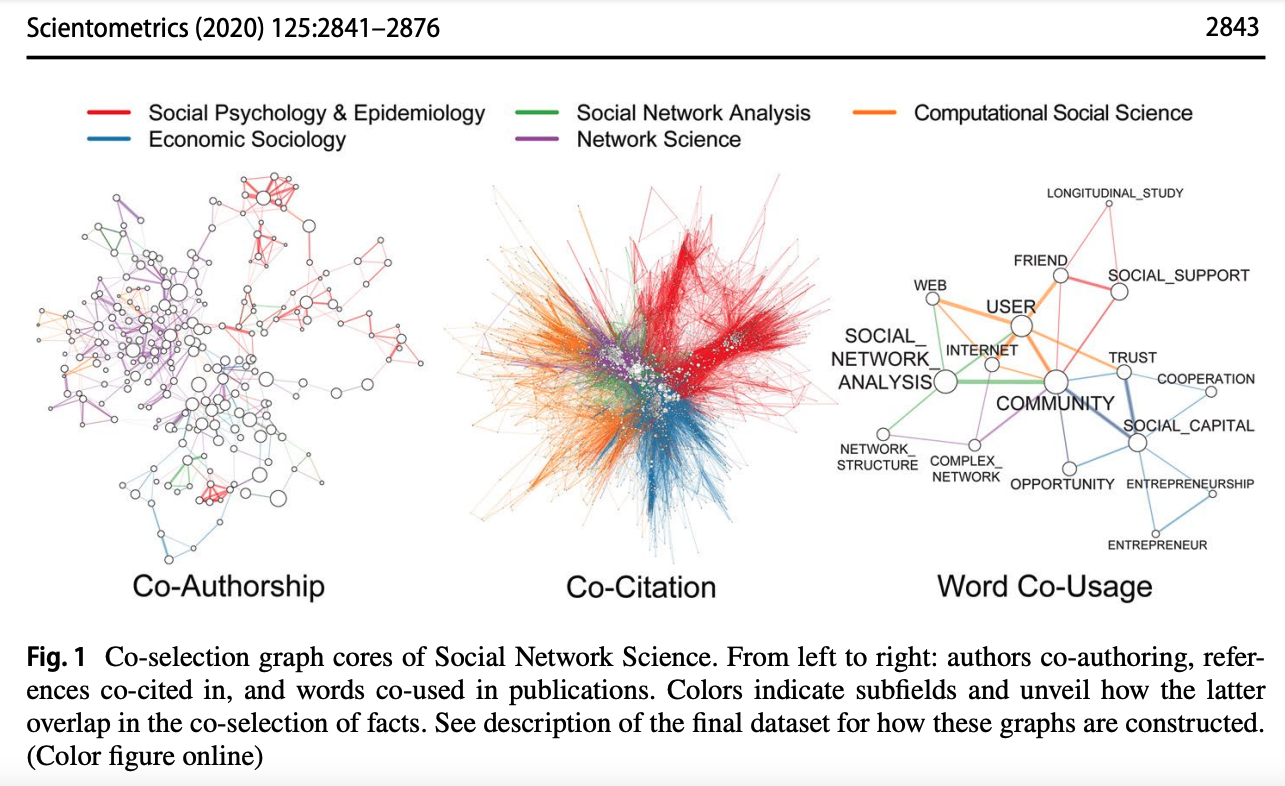



## 3.1 Representation

The simplest representation of a network is an **adjacency matrix**. It looks like this:

- Each row and column represents a node
- The value in the cell (i,j) represents the weight of the edge between node i and node j

For example, the following is an adjacency matrix for an **undirected network** with 4 nodes:

|   | A | B | C | D |
|---|---|---|---|---|
| A | 0 | 1 | 0 | 1 |
| B | 1 | 0 | 1 | 0 |
| C | 0 | 1 | 0 | 1 |
| D | 1 | 0 | 1 | 0 |

Alternatively, we can represent a network as a **list of edges**. Each edge is represented by a tuple of the form `(source, target, weight)`.

Converting the previous adjacency matrix to a list of edges would look like this:

| Source | Target | Weight |
|--------|--------|--------|
| A      | B      | 1      |
| A      | D      | 1      |
| B      | C      | 1      |
| C      | D      | 1      |

🤔 **How would the adjacency matrix and edge list change if the network was directed?**

## 3.2 NetworkX

[NetworkX](https://networkx.org/) is a Python library for creating, manipulating and analysing networks.

Let's create a network from our data.

### 3.2.1 Edgelist of the first scene

Let's start simple and create a list of edges just for the first scene:

In [540]:
sample = df_got.head(1)
sample[['characters', 'groups']]

characters              groups
0  [Gared, Waymar Royce, Will]  [None, None, None]

To make this a network, we will have to connect all the characters in the scene.

In [541]:
# Get the characters in the first scene
characters = sample['characters'].values[0]

# Create a list of all possible pairs of characters
# 💡 The itertools module is a great tool for this
pairs = list(itertools.combinations(characters, 2))

# This will eventually become our dataframe
pairs

[('Gared', 'Waymar Royce'), ('Gared', 'Will'), ('Waymar Royce', 'Will')]

Create edges is as simple as:

In [542]:
edges = pd.DataFrame([{'source': pair[0], 'target': pair[1]} for pair in pairs])
edges


source        target
0         Gared  Waymar Royce
1         Gared          Will
2  Waymar Royce          Will

Note that we are not mapping which character is talking to which other character, we do not have that info (I think). We are just creating a network of all the characters in the same scene.

### 3.2.2 Create a function to produce an edgelist per scene

In [543]:
sample

seasonNum  episodeNum      episodeTitle        episodeLink episodeAirDate  \
0          1           1  Winter Is Coming  /title/tt1480055/     2011-04-17   

                                  episodeDescription  \
0  Jon Arryn, the Hand of the King, is dead. King...   

                         openingSequenceLocations sceneStart sceneEnd  \
0  [King's Landing, Winterfell, The Wall, Pentos]    0:00:40  0:01:45   

   location   subLocation greensight altLocation warg flashback  \
0  The Wall  Castle Black        NaN         NaN  NaN       NaN   

                    characters              groups  
0  [Gared, Waymar Royce, Will]  [None, None, None]

In [544]:
def get_edges(scene):
    """Extracts the edges from the scenes.

    Args:
        x (dict): Dictionary containing the groups.

    Returns:
        edges (list): List of edges.
    """

    # Get the characters in the scene
    characters = scene['characters']

    # Create a list of all possible pairs of characters
    pairs = list(itertools.combinations(characters, 2))

    # Create a list of edges
    edges = [{'source': pair[0], 'target': pair[1], 
              'seasonNum': scene['seasonNum'], 'episodeNum': scene['episodeNum'],
              'location': scene['location'], 'subLocation': scene['subLocation'],
              'flashback': scene['flashback'] is True} 
             for pair in pairs]
    return pd.DataFrame(edges)

# 💡 Do you get why we need to use axis=1? And why we need to use .tolist()?
edgelist = pd.concat(df_got.apply(get_edges, axis=1).tolist())

Voilà! We now have an edge list for each scene.

In [545]:
edgelist.tail()

source              target  seasonNum  episodeNum           location  \
1     Ghost  Tormund Giantsbane          8           6  North of the Wall   
2  Jon Snow  Tormund Giantsbane          8           6  North of the Wall   
0     Ghost            Jon Snow          8           6  North of the Wall   
1     Ghost  Tormund Giantsbane          8           6  North of the Wall   
2  Jon Snow  Tormund Giantsbane          8           6  North of the Wall   

          subLocation  flashback  
1            The Wall      False  
2            The Wall      False  
0  The Haunted Forest      False  
1  The Haunted Forest      False  
2  The Haunted Forest      False

### 3.2.3 Explore the graph with NetworkX

In [546]:
G = nx.from_pandas_edgelist(edgelist, source='source', target='target', edge_attr=True, create_using=nx.Graph)

print(f'Number of nodes: {G.number_of_nodes()}')
print(f"Number of node attributes: {len(G.nodes[list(G.nodes)[0]])}")
print()

print(f'Number of edges: {G.number_of_edges()}')
print(f"Number of edge attributes: {len(G.edges[list(G.edges)[0]])}")
print(f"Edge attributes names: {list(G.edges[list(G.edges)[0]].keys())}")

Number of nodes: 576
Number of node attributes: 0

Number of edges: 4236
Number of edge attributes: 5
Edge attributes names: ['seasonNum', 'episodeNum', 'location', 'subLocation', 'flashback']


If we try to use the `nx.draw()` function, get get an... erm... interesting result:

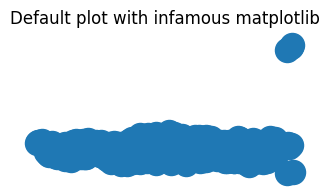

In [547]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4, 2))
plt.title('Default plot with infamous matplotlib')

nx.draw(G)

Drawing networks is notoriously difficult. There are tons of **algorithms** for network layout, and it is a very active area of research. 

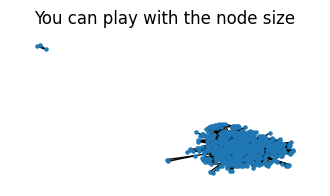

In [548]:
plt.figure(figsize=(4, 2))
plt.title('You can play with the node size')
nx.draw(G, with_labels=False, node_size=5)

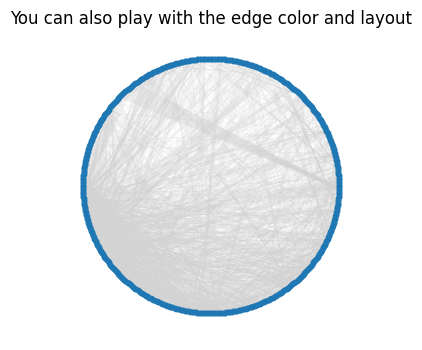

In [549]:
plt.figure(figsize=(4, 4))
plt.title('You can also play with the edge color and layout')
nx.draw(G, with_labels=False, node_size=10, edge_color='lightgrey', width=0.1, pos=nx.shell_layout(G))

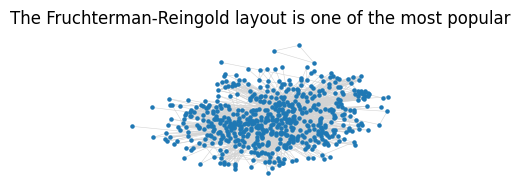

In [550]:
plt.figure(figsize=(4, 2))
plt.title('The Fruchterman-Reingold layout is one of the most popular')

# But it is slow
fr_layout = nx.fruchterman_reingold_layout(G, k=0.1, iterations=20)

nx.draw(G, with_labels=False, node_size=5, edge_color='lightgrey', width=0.4, pos=fr_layout)

What are these isolated nodes?

We can use the connected components algorithm to find the largest connected component:

In [551]:
df_components = pd.DataFrame([{'component': i, 'nodes': nodes}
                              for i, nodes in enumerate(nx.components.connected_components(G))])
df_components

component                                              nodes
0          0  {Khal Qorro, Karstark Lookout, Drogon, Fergus,...
1          1  {Young Cersei Lannister, Melara Hetherspoon, M...

In [552]:
df_components.iloc[1]['nodes']

{'Maggy', 'Melara Hetherspoon', 'Young Cersei Lannister'}

Let's locate these nodes in the network:

In [553]:
[G.edges(node, data=True) for node in df_components.iloc[1]['nodes']]

[EdgeDataView([('Young Cersei Lannister', 'Melara Hetherspoon', {'seasonNum': 5, 'episodeNum': 1, 'location': 'The Westerlands', 'subLocation': 'Outside Casterly Rock', 'flashback': True}), ('Young Cersei Lannister', 'Maggy', {'seasonNum': 5, 'episodeNum': 1, 'location': 'The Westerlands', 'subLocation': 'Outside Casterly Rock', 'flashback': True})]),
 EdgeDataView([('Melara Hetherspoon', 'Young Cersei Lannister', {'seasonNum': 5, 'episodeNum': 1, 'location': 'The Westerlands', 'subLocation': 'Outside Casterly Rock', 'flashback': True}), ('Melara Hetherspoon', 'Maggy', {'seasonNum': 5, 'episodeNum': 1, 'location': 'The Westerlands', 'subLocation': 'Outside Casterly Rock', 'flashback': True})]),
 EdgeDataView([('Maggy', 'Melara Hetherspoon', {'seasonNum': 5, 'episodeNum': 1, 'location': 'The Westerlands', 'subLocation': 'Outside Casterly Rock', 'flashback': True}), ('Maggy', 'Young Cersei Lannister', {'seasonNum': 5, 'episodeNum': 1, 'location': 'The Westerlands', 'subLocation': 'Outsid

This is equivalent to the following operation on the edgelist data frame:

In [554]:
edgelist[edgelist['source'].isin(df_components.iloc[1]['nodes']) | edgelist['target'].isin(df_components.iloc[1]['nodes'])]

source                  target  seasonNum  episodeNum  \
0  Melara Hetherspoon  Young Cersei Lannister          5           1   
0               Maggy      Melara Hetherspoon          5           1   
1               Maggy  Young Cersei Lannister          5           1   
2  Melara Hetherspoon  Young Cersei Lannister          5           1   

          location            subLocation  flashback  
0  The Westerlands  Outside Casterly Rock       True  
0  The Westerlands  Outside Casterly Rock       True  
1  The Westerlands  Outside Casterly Rock       True  
2  The Westerlands  Outside Casterly Rock       True

As this was a flashback, these characters (apart from Cersei Lannister) do not appear in the rest of the series. I could remove them from the network, but instead, I will rename 'Young Cersei Lannister' to 'Cersei Lannister' in the edgelist and recreate the network.

In [555]:
edgelist['source'] = edgelist['source'].apply(lambda x: 'Cersei Lannister' if x == 'Young Cersei Lannister' else x)
edgelist['target'] = edgelist['target'].apply(lambda x: 'Cersei Lannister' if x == 'Young Cersei Lannister' else x)

In [556]:
G = nx.from_pandas_edgelist(edgelist, source='source', target='target', edge_attr=True, create_using=nx.Graph)

nx.components.number_connected_components(G)

1

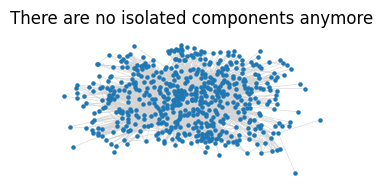

In [557]:
plt.figure(figsize=(4, 2))
plt.title('There are no isolated components anymore')

# But it is slow
fr_layout = nx.fruchterman_reingold_layout(G, k=0.1, iterations=20)

nx.draw(G, with_labels=False, node_size=5, edge_color='lightgrey', width=0.4, pos=fr_layout)

### 3.2.4 What are the characters that most interact with OTHER characters?

We can discover this by looking at the **degree** of each node.

In [558]:
df_degree = pd.DataFrame(nx.degree(G), columns=['character', 'degree']).sort_values('degree', ascending=False)
df_degree.head(10)

character  degree
5           Arya Stark     156
34    Tyrion Lannister     148
13         Sansa Stark     133
9             Jon Snow     122
35  Daenerys Targaryen     113
24     Jaime Lannister     112
15       Theon Greyjoy     108
6           Bran Stark     105
31      Sandor Clegane     103
23    Cersei Lannister     101

In [559]:
# Create a bar plot of the degree distribution
bar_plot = alt.Chart(df_degree).properties(
    title='Degree distributions are often skewed like this in real networks',
    width=600,
    height=400
)

# Let's do an altair plot of the degree distribution
bar_plot = bar_plot.mark_bar().encode(
    x=alt.X('degree:Q', bin=alt.Bin(maxbins=50), title='Degree'),
    y=alt.Y('count()', title='Count'),
)

bar_plot = bar_plot.configure_title(fontSize=20)
bar_plot = bar_plot.configure_axis(labelFontSize=20, titleFontSize=30, grid=False)
bar_plot = bar_plot.configure_legend(labelFontSize=20, titleFontSize=20)
bar_plot = bar_plot.configure_scale(maxSize=2000)

bar_plot

alt.Chart(...)

## 3.3 Interactive network visualisations with Altair

Someone has created a NetworkX to Altair converter ([Zsailer/nx_altair](https://github.com/Zsailer/nx_altair) on GitHub) that allows us to create interactive network visualisations using Altair.

**First, let's set some node attributes:**

In [590]:
def get_character_group(character):
    """Returns the group of a character.

    Args:
        character (str): Name of the character.

    Returns:
        group (str): Group of the character.
    """
    if character in df_characters_groups.index:
        group =  df_characters_groups.loc[character]['group']
        if isinstance(group, str):
            return group
        else:
            # Is one of the groups 'Include'? If so, remove it
            group = [g for g in group if g != 'Include']

            # If there is only one group, return it
            if len(group) == 1:
                return group[0]
            else:
                # There are some characters that are in multiple groups
                return group[0]

    else:
        return 'Other'

node_group = {node: get_character_group(node) for node in list(G.nodes) }

nx.set_node_attributes(G, node_group, 'group')
G.nodes(data=True)['Jon Snow']

{'group': 'Stark', 'degree': 122, 'name': 'Jon Snow'}

In [579]:
# Set degree as node attribute
degree = dict(G.degree)
nx.set_node_attributes(G, degree, 'degree')

In [588]:
# Set node name as node attribute
nx.set_node_attributes(G, {node: node for node in list(G.nodes)}, 'name')

In [592]:
pos = nx.fruchterman_reingold_layout(G, weight='degree', iterations=1000) # Compute before plotting

In [593]:
import nx_altair as nxa

# This is a large dataset for Altair
# https://altair-viz.github.io/user_guide/large_datasets.html
alt.data_transformers.disable_max_rows()

viz = nxa.draw_networkx(
    G, 
    pos=pos,
    node_size='degree',
    node_color='group',
    edge_color='#f0f0f0',
    node_tooltip=['name:N', 'group:N', 'degree:Q'],
).properties(
    title='Network visualisation with Altair',
    width=1000,
    height=400
)

viz

alt.LayerChart(...)

🏡 **TAKE-HOME EXERCISE:** Combine what you have learned about Altair and Networkx and customise the network visualisation above so that the colours are assigned by representativeness of the house. For example, the most important houses should get bolder colours, and the less important ones (say, Include) should get lighter colours.

# 👨‍💻 4: Exporting to Gephi

My favourite network layout is ForceAtlas2, which is available in Gephi (not on NetworkX).

Now, let's export the network to a Gephi file:

In [594]:
nx.write_gexf(G, '../output/got_network.gexf')

![](../output/got_network.svg)